# Asset Management Homework 3

### Aidan Cremins, Peyton Lewis, Joe Morris

Chosen ETFS:

1. U.S. Market = SPDR S&P 500 ETF Trust (SPY)
2. International Market (ex-U.S.) = Vanguard Total International Stock ETF (VXUS)
3. U.S. Bonds = iShares Core US Aggregate Bond ETF (AGG)
4. International Bonds (ex-U.S.) = Bloomberg Global Treasury ex-US Capped Index (BWX)
5. Other Asset Class = SPDR Gold Shares (GLD)

Questions:
1. Something might be wrong with the annualized returns, they don't seem to match what I found online
2. Do we find the optimal weights and then run it through the create_portfolio() function or do we have to iterate through create_portfolio()
3. I think for the simulation part if we don't need create_portfolio() we can do something like this: https://www.mlq.ai/python-for-finance-portfolio-optimization/ with the part about the Monte Carlo simulations
4. Do we change the titles on the graphs from the ticker to the actual strategy (i.e. SPY -> U.S. Market)?

### Necessary Imports

In [110]:
#Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime as dt, timedelta
import numpy as np

### Styles for plots

In [68]:
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 24
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 24
plt.style.use('fivethirtyeight')

### Read in ETF data and create returns

In [7]:
#Read in data about the 5 ETFs from WRDS
etfs = pd.read_csv('ETF Data.csv')
#Convert the date column to be a datetime data type
etfs['date'] = pd.to_datetime(etfs['date'], format="%m/%d/%Y")
#We noticed that BWX must've split on 9/28/2016, so we doubled all prices as an adjustment since the adjustment factor wasn't capturing this split
etfs.loc[(etfs['date']>=dt.strptime('9/29/2016', '%m/%d/%Y'))&(etfs['date']<=dt.strptime('12/31/2021', '%m/%d/%Y'))&(etfs['TICKER']=='BWX'),'PRC'] = etfs.loc[(etfs['date']>=dt.strptime('9/29/2016', '%m/%d/%Y'))&(etfs['date']<=dt.strptime('12/31/2021', '%m/%d/%Y'))&(etfs['TICKER']=='BWX'),'PRC']*2
#Make sure the dates are only on or after 12/31/2011 and on or before 12/31/2021
etfs = etfs[etfs['date']>=dt.strptime('12/31/2011', '%m/%d/%Y')]
etfs = etfs[etfs['date']<=dt.strptime('12/31/2021', '%m/%d/%Y')]
#Find the daily return of each ETF
etfs['return'] = etfs.groupby(['TICKER'])['PRC'].pct_change()

### Create ETF dataframe 
##### Ticker, Annualized return, Annualized Standard Deviation, Sharpe Ratio and Max Drawdown

In [8]:
#set up empty data frame with 5 columns
etf_df = pd.DataFrame(columns=['Ticker', 'Annualized Return', 'Annualized Std', 'Sharpe Ratio', 'Max Drawdown'])
#Iterate through each of the 5 ETFs
for ticker in etfs['TICKER'].unique():
    #Look at only one ETF at a time
    subset_df = etfs[etfs['TICKER'] == ticker]
    #Compute total return over the 10 years, then annualize
    total_return = subset_df['PRC'].iloc[-1]/subset_df['PRC'].iloc[0]-1
    annualized_return = (1+total_return)**(252/len(subset_df))-1
    #Get annualized standard deviation
    annualized_sd = subset_df['return'].std()*252**0.5
    #Find the Sharpe Ratio from the annualized return and standard deviation
    sharpe_ratio = annualized_return/annualized_sd
    #Get the max drawdown by subtracting the maximum price from the minimum price and dividing by the maximum price
    # max_drawdown = (subset_df['PRC'].min()-subset_df['PRC'].max())/(subset_df['PRC'].max())
    max_drawdown = ((np.maximum.accumulate(subset_df['PRC']) - subset_df['PRC'])/np.maximum.accumulate(subset_df['PRC'])).max()
    #Add results to dataframe
    etf_df = etf_df.append({'Ticker': ticker, 'Annualized Return': annualized_return, 'Annualized Std': annualized_sd, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown, 'Total Return':total_return}, ignore_index=True)

In [9]:
etf_df

,Ticker,Annualized Return,Annualized Std,Sharpe Ratio,Max Drawdown,Total Return
0,VXUS,0.042144,0.168755,0.249733,0.399215,0.510299
1,SPY,0.140734,0.161864,0.869460,0.341047,2.725322
2,AGG,0.003626,0.040569,0.089368,0.095792,0.036808
3,GLD,0.009262,0.150608,0.061499,0.421116,0.096460
4,BWX,-0.004962,0.072421,-0.068513,0.178439,-0.048469


### Iterate through the ETFs and plot the returns

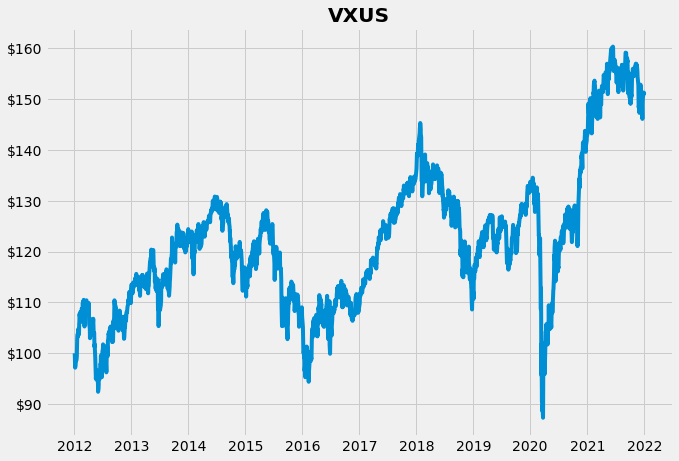

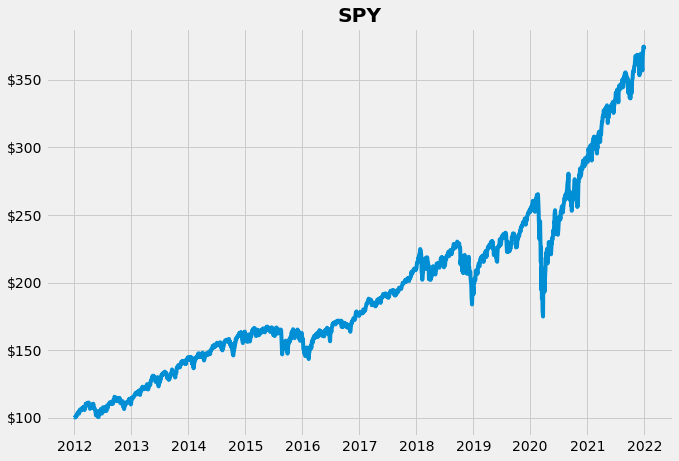

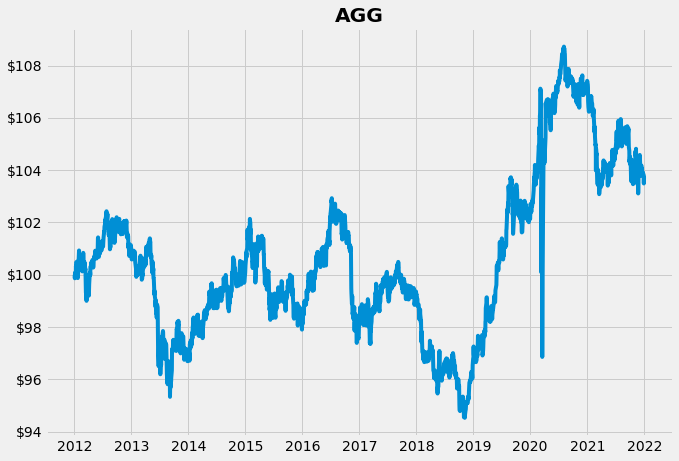

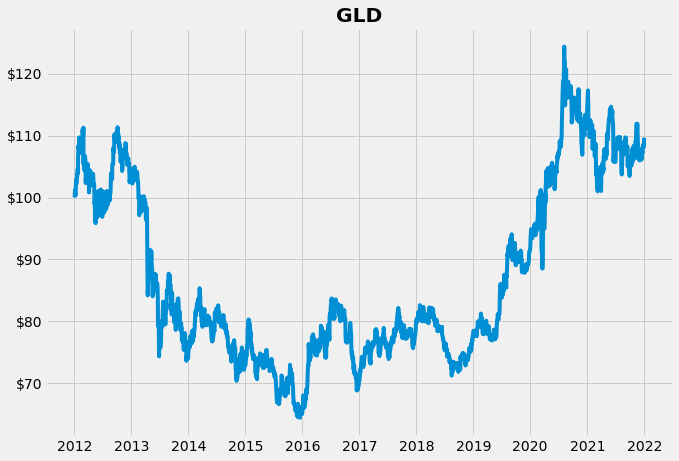

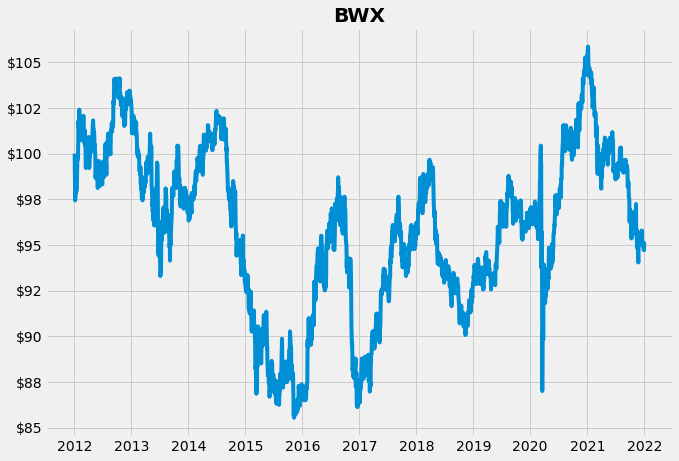

In [112]:
#Iterate through each ETF again
for ticker in etfs['TICKER'].unique():
    cumulative_returns = []
    subset_df = etfs[etfs['TICKER'] == ticker]

    for day in range(len(subset_df)):
        #For each day, get cumulative return up until that point
        cumulative_ret = (1+subset_df['return'].iloc[:day+1]).prod()
        #Add these cumulative returns to a list and multiply by 100 since we're looking at $100 invested
        cumulative_returns.append(cumulative_ret*100)
    #Plot performance of $100 invested at 12/31/2011 over time
    plt.plot(subset_df['date'], cumulative_returns)
    plt.title(ticker)
    plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

    plt.show()

### Add a month column

In [11]:
#Make a new column for what month it is
etfs['month'] = etfs['date'].dt.to_period('M')

### Function to plot the cumulative returns

In [121]:
def cumulative_plot(data):
    #Since each ETF has the same total value for each date, we can just take the mean to extract the total value for a given date
    total_values = data.groupby('date')['total_val'].mean()
    #We then compute the percentage change in total value to get the daily portfolio return
    daily_returns = total_values.pct_change()
    #Make index of daily returns a column called date
    daily_returns = daily_returns.reset_index()
    #Set index of daily returns to be number 
    daily_returns.index = range(len(daily_returns))
    cumulative_returns = []
    for day in range(len(daily_returns)):
        #For each day, get cumulative return up until that point
        cumulative_ret = (1+daily_returns['total_val'].iloc[:day+1]).prod()
        #Add these cumulative returns to a list and multiply by 100 since we're looking at $100 invested
        cumulative_returns.append(cumulative_ret*100)
    #Plot performance of $100 invested at 12/31/2011 over time
    figure = plt.plot(daily_returns['date'], np.array(cumulative_returns))
    plt.title('Portfolio Performance')
    plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    return figure

### Function to calculate the annualized returns, standard deviation, sharpe ratio and max drawdown

In [60]:
def portfolio_analysis(data):
    #set up empty data frame with 5 columns
    result_df = pd.DataFrame(columns=['Annualized Return', 'Annualized Std', 'Sharpe Ratio', 'Max Drawdown'])
    #Since each ETF has the same total value for each date, we can just take the mean to extract the total value for a given date
    total_values = data.groupby('date')['total_val'].mean()
    #We then compute the percentage change in total value to get the daily portfolio return
    daily_returns = total_values.pct_change()
    #Compute total return over the 10 years, then annualize
    total_return = (data['total_val'].iloc[-1]/data['total_val'].iloc[0])-1
    annualized_return = (1+total_return)**(252/len(data['date'].unique()))-1
    #Get annualized standard deviation
    annualized_sd = daily_returns.std()*np.sqrt(252)
    #Find the Sharpe Ratio from the annualized return and standard deviation
    sharpe_ratio = annualized_return/annualized_sd
    #Get the max drawdown 
    max_drawdown = ((np.maximum.accumulate(subset_df['PRC']) - subset_df['PRC'])/np.maximum.accumulate(subset_df['PRC'])).max()
    #Add results to dataframe
    result_df = result_df.append({'Annualized Return': annualized_return, 'Annualized Std': annualized_sd, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown, 'Total Return':total_return}, ignore_index=True)
    
    return result_df

### Function to create a portfolio, which reweights monthly

In [103]:
def create_portfolio(data,tickers,target_weights,min_date,max_date,initial_investment):
    etfs = data
    etfs = etfs[etfs['date']>=dt.strptime(min_date, '%m/%d/%Y')]
    etfs = etfs[etfs['date']<=dt.strptime(max_date, '%m/%d/%Y')]
    etfs = etfs[etfs['TICKER'].isin(tickers)]
    
    #Find the earliest date in the data
    first_date = etfs['date'].min()

    #Find the last day of each month
    last_days = etfs.groupby('month')['date'].max()
    
    for i in range(len(tickers)):
            #For the very first day of the data, update quantity so that it times the price divided by the total portfolio value is equal to the target weight
            #For now, the portfolio value is the initial investment value
            etfs.loc[(etfs['date']==first_date) & (etfs['TICKER']==tickers[i]), 'quantity'] = target_weights[i]/etfs.loc[(etfs['date']==first_date) & (etfs['TICKER']==tickers[i]), 'PRC']*initial_investment

    #For all na values in the quantity column (i.e. not the very first day), set the quantity to be the same as the previous day so all quantities match the first day of the month
    etfs['quantity'] = etfs['quantity'].fillna(method='ffill')
    #For all na values in the weighted value column (i.e. not the first day of the month), set the weighted value to be the quantity times the price
    etfs['weighted_val'] = etfs['quantity']*etfs['PRC']
    #Set total value column equal to sum of weighted values on that day
    etfs['total_val'] = etfs.groupby('date')['weighted_val'].transform('sum')
    #Compute weight as the weighted value of the ETF divided by the total value on that day
    etfs['weight'] = etfs['weighted_val']/etfs['total_val']

    #For all days except first_date, set quantity to na
    etfs.loc[etfs['date']!=first_date, 'quantity'] = np.nan
    for date in last_days.values:
        for i in range(len(tickers)):
                etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'quantity'] = target_weights[i]/etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'PRC']*etfs.loc[(etfs['date']==date) & (etfs['TICKER']==tickers[i]), 'total_val']

    #Re-establish quantity, weighted value, total value, and weight columns 
    etfs['quantity'] = etfs['quantity'].fillna(method='ffill')
    etfs['weighted_val'] = etfs['quantity']*etfs['PRC']
    etfs['total_val'] = etfs.groupby('date')['weighted_val'].transform('sum')
    etfs['weight'] = etfs['weighted_val']/etfs['total_val']
    return [portfolio_analysis(etfs),cumulative_plot(etfs), etfs]
    

### Get the returns of our target weights

,Annualized Return,Annualized Std,Sharpe Ratio,Max Drawdown,Total Return
0,0.063609,0.095564,0.665619,0.178439,0.851404


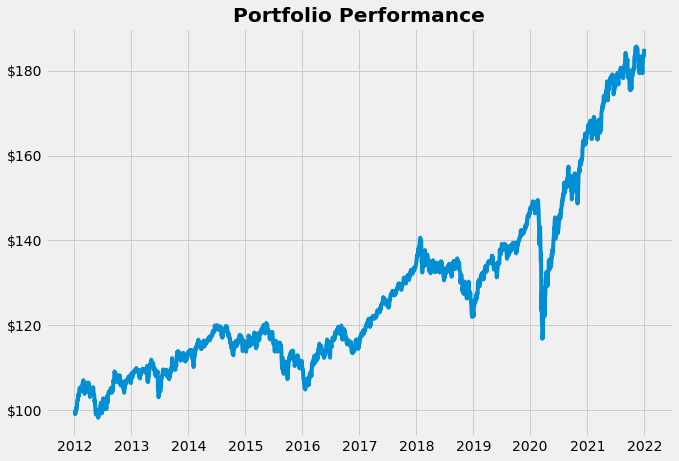

In [122]:
target_weights = [0.3, 0.25, 0.2, 0.15, 0.1]
tickers = etfs['TICKER'].unique()
target = create_portfolio(etfs,tickers,target_weights,'1/3/2012','12/31/2021',100)[0]
target

## Weight Optimization  

### Get ETF returns dataframe

In [17]:
#Get a dataframe indexed by date and columns for each etf with the return of each etf on that day
etf_returns = pd.DataFrame()
for i in range(len(tickers)):
    etf_returns[tickers[i]] = etfs.loc[etfs['TICKER']==tickers[i], 'return'].values
etf_returns.index = etfs.loc[etfs['TICKER']==tickers[i], 'date'].values
#Drop the first row because it's na
etf_returns = etf_returns.dropna()

### Get the ETF prices dataframe

In [18]:
#Get a dataframe indexed by date and columns for each etf with the return of each etf on that day
etf_prices = pd.DataFrame()
for i in range(len(tickers)):
    etf_prices[tickers[i]] = etfs.loc[etfs['TICKER']==tickers[i], 'PRC'].values
etf_prices.index = etfs.loc[etfs['TICKER']==tickers[i], 'date'].values

### Function to find the sharpe ratio

In [19]:
def get_sharpe_ratio(data, weights):
    #Get list of prices on last day of etfs
    final_prices = []
    for i in range(len(tickers)):
        final_prices.append(etfs.loc[etfs['TICKER']==tickers[i], 'PRC'].values[-1])
    first_prices = []
    for i in range(len(tickers)):
        first_prices.append(etfs.loc[etfs['TICKER']==tickers[i], 'PRC'].values[0])
    cum_returns = (np.array(final_prices)-np.array(first_prices))/first_prices
    total_return = np.dot(weights,cum_returns)
    annualized_return = (1+total_return)**(252/(len(etfs)/len(tickers)))-1
    for i in range(len(weights)):
        etf_returns[tickers[i]] = etf_returns[tickers[i]]*weights[i]
    #Get portfolio return by adding together weighted returns
    etf_returns['portfolio_return'] = etf_returns.sum(axis=1)

    #Get annualized standard deviation
    annualized_sd = etf_returns['portfolio_return'].std()*252**0.5
    #Find the Sharpe Ratio from the annualized return and standard deviation
    sharpe_ratio = annualized_return/annualized_sd
    return weights,sharpe_ratio

### Run the optimization to find the optimal weights to maximize the sharpe ratio

In [ ]:
weights_df = pd.DataFrame(columns=['weights','sharpe_ratio'])
all_weights = []
for i in range(100000):
    weights = np.zeros(5)
    weights[0] = np.random.uniform(0,.45)
    weights[1] = np.random.uniform(0,.45)
    weights[2] = np.random.uniform(0,.45)
    weights[3] = np.random.uniform(0,.45)
    weights[4] = np.random.uniform(0,.45)
    weights = weights/np.sum(weights)
    all_weights.append(weights)

weights_df['weights'] = all_weights

weights_df['sharpe_ratio'] = weights_df['weights'].apply(lambda x: get_sharpe_ratio(etf_returns,x)[1])
#Subset weights_df so that max of weights is less than 0.45
weights_df = weights_df.loc[weights_df['weights'].apply(lambda x: max(x))<=0.45]
#Return the row with the highest sharpe ratio and print weights and sharpe ratio
top_sr = weights_df.loc[weights_df['sharpe_ratio'].idxmax()]

##### Report the optimal weights and the sharpe ratio

In [130]:
print('Optimal Weights:\t', top_sr['weights'])
print('Sum of optimal weights:\t', top_sr['weights'].sum())
print('Sharpe Ratio:\t\t', top_sr['sharpe_ratio'])

Optimal Weights:	 [0.4358855  0.44735937 0.01992597 0.02021136 0.0766178 ]
Sum of optimal weights:	 1.0
Sharpe Ratio:		 0.9334588991132514


### Plot the cumulative returns of the optimal sharpe ratio portfolio

,Annualized Return,Annualized Std,Sharpe Ratio,Max Drawdown,Total Return
0,0.093442,0.141338,0.661128,0.178439,1.4406


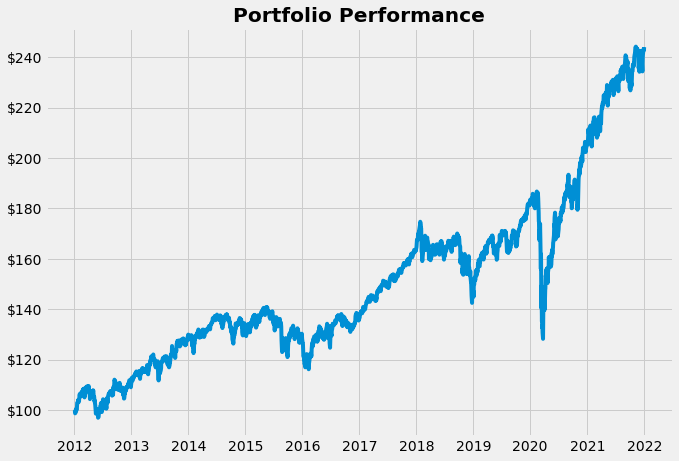

In [133]:
weights_new =  [0.4358855,  0.44735937, 0.01992597, 0.02021136, 0.0766178 ]

# can use the weights from the above code (top_sr['weights']) or use the weights from a previous run (weights_new)
optimal = create_portfolio(etfs,tickers,top_sr['weights'],'1/3/2012','12/31/2021',100)[0]
optimal

### Plot the cumulative returns of the optimal sharpe ratio portfolio and the target portfolio

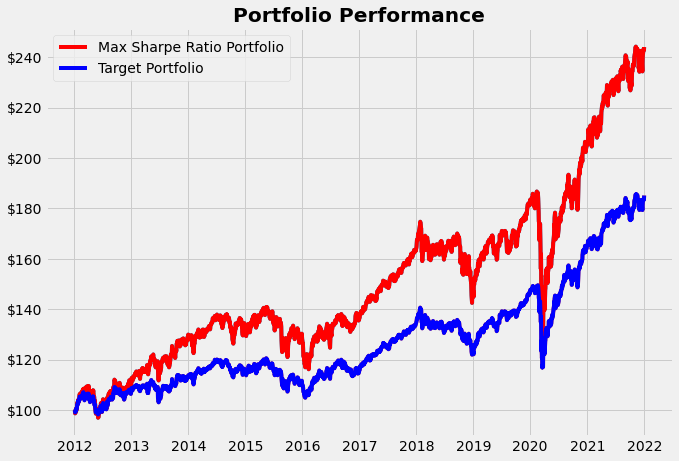

In [125]:
port1 = create_portfolio(etfs,tickers,weights_new,'1/3/2012','12/31/2021',100)[2]
port2 = create_portfolio(etfs,tickers,target_weights,'1/3/2012','12/31/2021',100)[2]

# sort the data by date
port1 = port1.sort_values(by='date')
port2 = port2.sort_values(by='date')

plt.plot(port1['date'],port1['total_val'],label='Max Sharpe Ratio Portfolio', color='red')
plt.plot(port2['date'],port2['total_val'],label='Target Portfolio', color='blue')
plt.legend()
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.title('Portfolio Performance')
plt.show()


### Statistics from the max sharpe ratio portfolio and the target portfolio

In [141]:
df = pd.concat([optimal, target], axis=0)
df.index = ['Max Sharpe Ratio Portfolio', 'Target Portfolio']
df

,Annualized Return,Annualized Std,Sharpe Ratio,Max Drawdown,Total Return
Max Sharpe Ratio Portfolio,0.093442,0.141338,0.661128,0.178439,1.440600
Target Portfolio,0.063609,0.095564,0.665619,0.178439,0.851404
